# (E05)5th-Project-Spectrogram_classification
***********************************************************************************************************

## 1. 데이터 처리와 분류

In [1]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

In [2]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


      일단 Exploration의 wavform데이터를 불러와줍니다

In [3]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [4]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

      데이터에 각각 정답에 따라 라벨링을 해주고 잘 붙었나 확인해 줍시다.

In [5]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], label_data, test_size=0.1, shuffle=True)
print(train_wav.shape)

del speech_data

(45558, 8000)


      Train data와 Test data를 나눠줍니다.
      그리고 쓸모없어진 speech data를 삭제해 메모리를 확보해줍니다.

In [6]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

      위 함수를 통해서 wavform을 spectrogram으로 변환시켜줄겁니다.

In [7]:
train_spec=[]

for wav in train_wav:

    train_spec.append(wav2spec(wav))

train_spec = np.array(train_spec)
print(train_spec.shape)

test_spec=[]

for wav in test_wav:

    test_spec.append(wav2spec(wav))

test_spec = np.array(test_spec)
print(test_spec.shape)

(45558, 130, 126)
(5062, 130, 126)


      하나씩 불러와서 변환하고 빈 리스트에 집어넣고 다시 array로 변환시켜줍니다.
      트레인과 테스트 각각 실행시켜 줍니다.

In [8]:
batch_size = 32
max_epochs = 20

In [9]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label

In [10]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)

<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126), (None, 12)), types: (tf.float32, tf.float32)>


      트레인 데이터셋과 테스트 데이터셋을 만들어줍니다.

## 2. 모델 구성하기

## 1) 1-D CNN MODEL

In [11]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126)) #스펙트럼에 맞춰서 인풋 텐서를 맞춰줍니다.

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 130, 126)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 130, 32)           36320     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 130, 32)           9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 65, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 65, 64)            18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 65, 64)            36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 32, 64)            0     

In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[es, mc]
                    )

Epoch 1/20
1420/1423 [============================>.] - ETA: 0s - loss: 1.3755 - acc: 0.5304
Epoch 00001: val_acc improved from -inf to 0.67840, saving model to best_model.h5
1423/1423 [==============================] - 10s 7ms/step - loss: 1.3743 - acc: 0.5308 - val_loss: 0.9297 - val_acc: 0.6784
Epoch 2/20
1418/1423 [============================>.] - ETA: 0s - loss: 0.6549 - acc: 0.7820
Epoch 00002: val_acc improved from 0.67840 to 0.82951, saving model to best_model.h5
1423/1423 [==============================] - 10s 7ms/step - loss: 0.6544 - acc: 0.7822 - val_loss: 0.5160 - val_acc: 0.8295
Epoch 3/20
1416/1423 [============================>.] - ETA: 0s - loss: 0.4466 - acc: 0.8508
Epoch 00003: val_acc improved from 0.82951 to 0.86155, saving model to best_model.h5
1423/1423 [==============================] - 10s 7ms/step - loss: 0.4461 - acc: 0.8509 - val_loss: 0.4105 - val_acc: 0.8616
Epoch 4/20
1420/1423 [============================>.] - ETA: 0s - loss: 0.3348 - acc: 0.8888
Epoc

      학습결과 생각보다 학습하는데 시간이 오래걸리지 않았고 4번이상 val loss가 증가할 경우 멈추게 하고 epoch를 20번 하게 했는데 20번을 채웠습니다. 결과적으로 마지막 val accuarcy는 약 94%인 모델이 저장되었습니다.

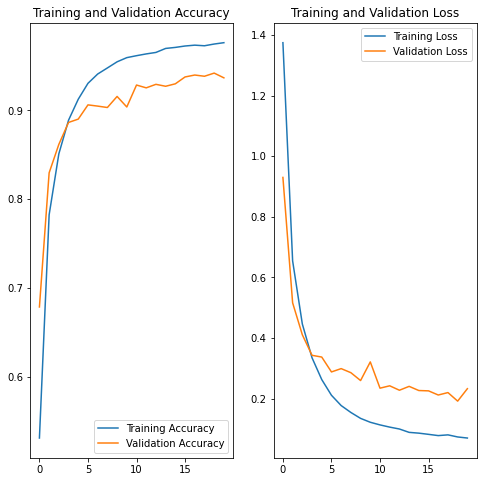

In [13]:
import matplotlib.pyplot as plt

acc = history_spec.history['acc']
val_acc = history_spec.history['val_acc']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

      Training 그래프는 일정한 log그래프의 양상을 보이는데 Vaildation그래프는 log양상인데 오락가락하는 모양을 보입니다.

In [14]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_dataset)[1]))

159/159 [==============================] - 17s 107ms/step - loss: 0.1916 - acc: 0.9417

 테스트 정확도: 0.9417


      저장된 epoch가 19일때의 모델의 정확도는 약 94%를 보였습니다.

In [15]:
del model_spec
del history_spec # 메모리를 확보해줍니다.

## 2) 2-D CNN MODEL

In [16]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1)) #이번엔 2d이므로 행렬 모양을 맞춰줍니다.

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec = tf.keras.Model(input_tensor, output_tensor)

model_spec.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 130, 126, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 130, 126, 32)      2624      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 130, 126, 32)      82976     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 65, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 65, 63, 64)        165952    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 65, 63, 64)        331840    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 31, 64)        0   

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_2D_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_spec = model_spec.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[es, mc]
                    )

Epoch 1/20
1423/1423 [==============================] - ETA: 0s - loss: 0.6627 - acc: 0.7788
Epoch 00001: val_acc improved from -inf to 0.91713, saving model to best_2D_model.h5
1423/1423 [==============================] - 202s 142ms/step - loss: 0.6627 - acc: 0.7788 - val_loss: 0.2807 - val_acc: 0.9171
Epoch 2/20
1423/1423 [==============================] - ETA: 0s - loss: 0.2355 - acc: 0.9257
Epoch 00002: val_acc improved from 0.91713 to 0.94422, saving model to best_2D_model.h5
1423/1423 [==============================] - 201s 142ms/step - loss: 0.2355 - acc: 0.9257 - val_loss: 0.1831 - val_acc: 0.9442
Epoch 3/20
1423/1423 [==============================] - ETA: 0s - loss: 0.1648 - acc: 0.9477
Epoch 00003: val_acc did not improve from 0.94422
1423/1423 [==============================] - 201s 141ms/step - loss: 0.1648 - acc: 0.9477 - val_loss: 0.1777 - val_acc: 0.9426
Epoch 4/20
1423/1423 [==============================] - ETA: 0s - loss: 0.1283 - acc: 0.9580
Epoch 00004: val_acc imp

      윗 모델과 같은 조건에서 학습을 종료하게 설정하니 이번에는 epoch가 9회일때 종료되었고 저장은 8일 때 실행됬습니다. 이때의 val loss는 약 13%, val accuracy는 약 96% 입니다.

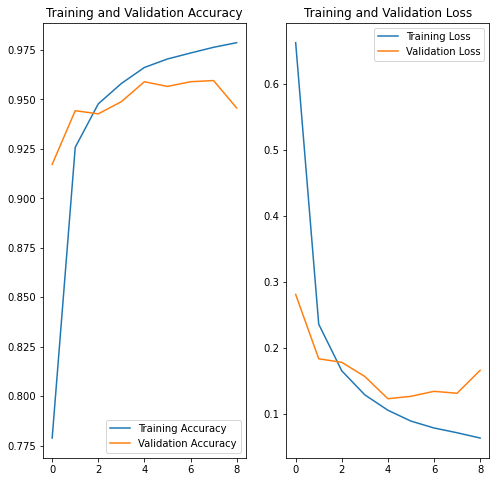

In [18]:
import matplotlib.pyplot as plt

acc = history_spec.history['acc']
val_acc = history_spec.history['val_acc']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

      1-D모델과 마찬가지로 트레이닝 그래프는 log그래프를 따라가지만 Vaildation그래프는 훨씬 심한 변화를 보였습니다. 이는 과적합으로 인한 오차로 보입니다.

In [19]:
loaded_model = load_model('best_2D_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_dataset)[1]))

159/159 [==============================] - 22s 138ms/step - loss: 0.1310 - acc: 0.9593

 테스트 정확도: 0.9593


      정확도는 약 96%로 1-D CNN 모델보다 약 2%가량 증가한 것을 확인했습니다.

In [20]:
del model_spec
del history_spec  # 메모리 확보

## 3) 1-D CNN  Skip-Connection model

In [21]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 130, 126)]   0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 130, 32)      36320       input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 130, 32)      9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 65, 32)       0           conv1d_11[0][0]                  
____________________________________________________________________________________________

      예제에서 진행한 skip-connection을 추가해줍니다.

In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_1D_skip_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_spec_skip = model_spec_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[es, mc]
                    )

Epoch 1/20
1418/1423 [============================>.] - ETA: 0s - loss: 1.0633 - acc: 0.6407
Epoch 00001: val_acc improved from -inf to 0.75198, saving model to best_1D_skip_model.h5
1423/1423 [==============================] - 11s 7ms/step - loss: 1.0621 - acc: 0.6411 - val_loss: 0.7269 - val_acc: 0.7520
Epoch 2/20
1422/1423 [============================>.] - ETA: 0s - loss: 0.6097 - acc: 0.7957
Epoch 00002: val_acc improved from 0.75198 to 0.82496, saving model to best_1D_skip_model.h5
1423/1423 [==============================] - 10s 7ms/step - loss: 0.6095 - acc: 0.7957 - val_loss: 0.5088 - val_acc: 0.8250
Epoch 3/20
1420/1423 [============================>.] - ETA: 0s - loss: 0.4327 - acc: 0.8563
Epoch 00003: val_acc improved from 0.82496 to 0.86313, saving model to best_1D_skip_model.h5
1423/1423 [==============================] - 12s 8ms/step - loss: 0.4323 - acc: 0.8565 - val_loss: 0.4177 - val_acc: 0.8631
Epoch 4/20
1417/1423 [============================>.] - ETA: 0s - loss: 0

      학습결과 Epoch가 18번일때 멈췄고 val loss는 약 20% val accuaracy는 94%였습니다. 

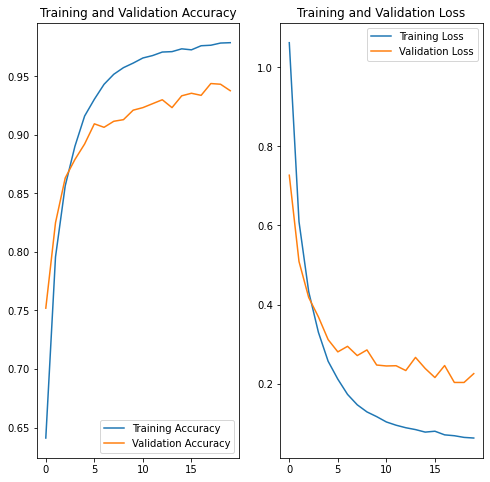

In [24]:
import matplotlib.pyplot as plt

acc = history_spec_skip.history['acc']
val_acc = history_spec_skip.history['val_acc']

loss=history_spec_skip.history['loss']
val_loss=history_spec_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

      성능 그래프를 확인하자 1-D CNN 모델과 크나큰 변화는 없었습니다.

In [25]:
loaded_model = load_model('best_1D_skip_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_dataset)[1]))

159/159 [==============================] - 5s 29ms/step - loss: 0.2028 - acc: 0.9439

 테스트 정확도: 0.9439


      성능은 약 94%로 1-D CNN 보단 약 0.2% 증가했습니다.

In [26]:
del model_spec_skip
del history_spec_skip

## 4) 2-D CNN  Skip-Connection model

In [28]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_spec_skip_2D = tf.keras.Model(input_tensor, output_tensor)

model_spec_skip_2D.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 130, 126, 32) 2624        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 130, 126, 32) 82976       conv2d_14[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_15[0][0]                  
____________________________________________________________________________________________

      마지막으로 2-D CNN 모델에 Skip-Connection을 추가해줬습니다.

In [30]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

optimizer=tf.keras.optimizers.Adam(1e-4)
model_spec_skip_2D.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_2D_skip_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history_spec_skip_2D = model_spec_skip_2D.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[es, mc]
                    )

Epoch 1/20
1423/1423 [==============================] - ETA: 0s - loss: 0.7003 - acc: 0.7729
Epoch 00001: val_acc improved from -inf to 0.91614, saving model to best_2D_skip_model.h5
1423/1423 [==============================] - 216s 152ms/step - loss: 0.7003 - acc: 0.7729 - val_loss: 0.2876 - val_acc: 0.9161
Epoch 2/20
1423/1423 [==============================] - ETA: 0s - loss: 0.2079 - acc: 0.9341
Epoch 00002: val_acc improved from 0.91614 to 0.94620, saving model to best_2D_skip_model.h5
1423/1423 [==============================] - 217s 152ms/step - loss: 0.2079 - acc: 0.9341 - val_loss: 0.1685 - val_acc: 0.9462
Epoch 3/20
1423/1423 [==============================] - ETA: 0s - loss: 0.1367 - acc: 0.9563
Epoch 00003: val_acc improved from 0.94620 to 0.95708, saving model to best_2D_skip_model.h5
1423/1423 [==============================] - 216s 151ms/step - loss: 0.1367 - acc: 0.9563 - val_loss: 0.1325 - val_acc: 0.9571
Epoch 4/20
1423/1423 [==============================] - ETA: 0s 

      학습결과 epoch는 14번쨰에 멈췄고 12번일 째 모델에 저장되었습니다. val loss는 9%이고 val accuaracy는 약 98%입니다. 

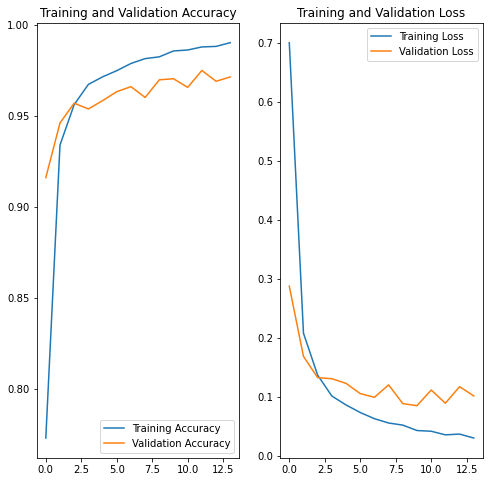

In [31]:
import matplotlib.pyplot as plt

acc = history_spec_skip_2D.history['acc']
val_acc = history_spec_skip_2D.history['val_acc']

loss=history_spec_skip_2D.history['loss']
val_loss=history_spec_skip_2D.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

      학습모델의 validation그래프가 훨씬 트레이닝 그래프에 붙어서 가는것을 확인할 수 있었습니다.

In [32]:
loaded_model = load_model('best_2D_skip_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(test_dataset)[1]))

159/159 [==============================] - 10s 62ms/step - loss: 0.0891 - acc: 0.9751

 테스트 정확도: 0.9751


      정확도도 약 98%로 가장 높았습니다.

********************************************************************************************************
## 3. 평가와 결론

      전체적으로 모두 성능이 나쁘진 않았지만 Spectrogram의 데이터가 2D로 구성되어있는 점에서 2-d CNN 모델이 더 높은 성능을 보인거같습니다. 그리고 Skip connection도 2-d에서 더 월등한 성능의 향상을 보여줬습니다. 
      
      이번 프로젝트의 경우 데이터의 Spectrogram처리하는 것이랑 메모리 확보가 더 중요한 프로젝트였던것같습니다.